# Repeated Classification

We will explore the Repeated Classification simulator, based on the following paper:

Hashimoto, T., Srivastava, M., Namkoong, H., & Liang, P. (2018, July).
Fairness without demographics in repeated loss minimization. In International
Conference on Machine Learning. (https://arxiv.org/abs/1806.08010)

In [1]:
import whynot as wn
import numpy as np
from whynot import repeated_classification
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from whynot.simulators.repeated_classification.experiments import (
    abs_loss,
    constant,
    dro,
    erm,
    exponential_retention,
    extract_outcomes,
    median_dist_0,
    median_dist_1,
    median_dist_2,
    sample_initial_states_median,
)

## Median Estimation

We can explore median estimation using the Repeated Classification framework.

Say we have three groups, with unequal populations, each with an isotropic Gaussian distribution in $\mathbb{R}^3$. We want to estimate the median in such a way that is fair to all groups, i.e. there is no group for which the estimate is very inaccurate.

In [2]:
rng = np.random.RandomState(5)

baseline_growth = np.array([1000, 300, 300])  # constant amount each group grows every step, in expectation
group_distributions = [median_dist_0, median_dist_1, median_dist_2]

group_features = []
for population, distribution in zip(baseline_growth, group_distributions):
    features, labels = distribution(population, rng)
    group_features.append(features)

Here we visualize the groups.

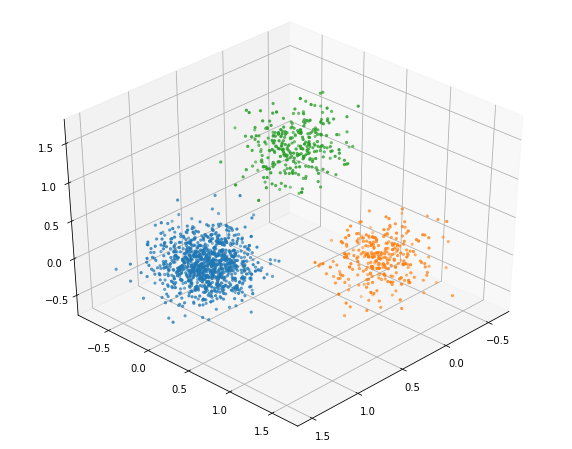

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.view_init(elev=37, azim=44)

for g in group_features:
    x, y, z = zip(*g)
    ax.scatter3D(x, y, z, s=5)

plt.show()

We have `K=3` groups, over which the smallest one's proportion is lower bounded by `0.15`. We want to find the `constant` predictor for a "median" that (naively) minimizes $l_1$ loss `abs_loss` over all of the individual points. We model the retention rate of users going into the next step in each group as an exponentially decreasing function `exponential_retention` of the average group loss from the current step's estimate. Since we are naively minimizing the loss over all of the individuals, we use Empirical Risk Minimization (`erm`) to train the estimator.

This is a method to create a config for this setup with `5` steps:

In [4]:
def construct_config_median():
    return repeated_classification.Config(
        K=3,
        min_proportion=0.15,
        baseline_growth=baseline_growth,
        group_distributions=group_distributions,
        classifier_func=constant,
        loss=abs_loss,
        user_retention=exponential_retention,
        train_classifier=erm,
        end_time=5,
    )

The following defines a corresponding `DynamicsExperiment`. The `intervention` is to use a different training algorithm for the estimator, Distributionally Robust Optimization (`dro`), which attempts to minimize the worst-case group loss, instead of average loss over all individuals ignoring groups (`erm`). Using DRO is more in line with our original goal.

In [5]:
from whynot.dynamics import DynamicsExperiment

MedianEstimationExperiment = DynamicsExperiment(
    name="MedianEstimationExperiment",
    description="Median estimation experiment.",
    simulator=repeated_classification,
    simulator_config=construct_config_median,
    intervention=repeated_classification.Intervention(time=0, train_classifier=dro),
    state_sampler=sample_initial_states_median,
    propensity_scorer=0.5,
    outcome_extractor=extract_outcomes,
    covariate_builder=lambda run: run.states[-1].classifier_params,
)

Here we run the experiment and extract the trained parameters from the runs using ERM and DRO, respectively, after 5 steps.

In [6]:
result = MedianEstimationExperiment.run(20, seed=5)
erm_params = result.covariates[(1 - result.treatments).astype(bool)]
dro_params = result.covariates[result.treatments.astype(bool)]

Even after only 5 steps, DRO maintains a relatively fair estimate of the median, while ERM drastically prefers the group with larger population.

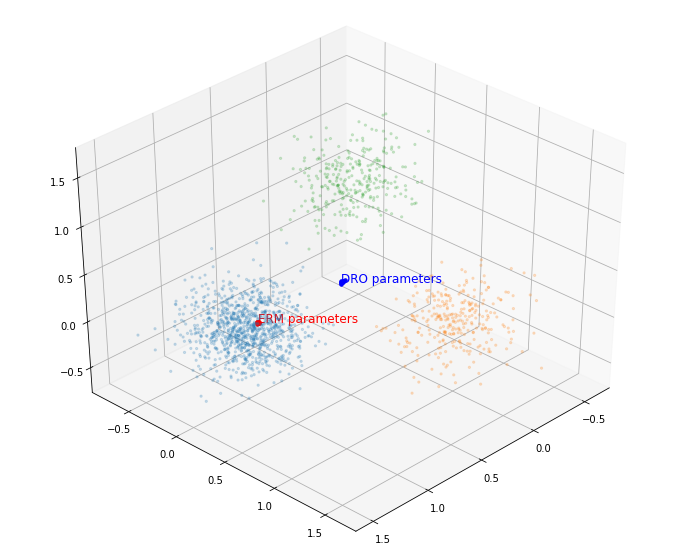

In [7]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection="3d")
ax.view_init(elev=37, azim=44)

for g in group_features:
    x, y, z = zip(*g)
    ax.scatter3D(x, y, z, s=5, alpha=0.2)

for i, p in enumerate(erm_params):
    ax.scatter3D(*p, s=12, label='ERM', c='red')
    if i == 0:
        ax.text(*p, 'ERM parameters', c='red', size=12)

for i, p in enumerate(dro_params):
    ax.scatter3D(*p, s=12, label='DRO', c='blue')
    if i == 0:
        ax.text(*p, 'DRO parameters', c='blue', size=12)

plt.show()